# Exploratory Data Analysis

This file contains the code for question 1 of task 1 of project 1 in Machine Learning for Healthcare offered at ETH Zurich in FS2024

## Packages and Presets

In [105]:
import numpy as np
import pandas as pd
import plotnine as pn
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from skimpy import skim, clean_columns
import scipy.stats as stats
# robust covariance estimator:
from sklearn.covariance import MinCovDet

import warnings
warnings.filterwarnings("ignore") #sanest python user

## Basic Summary Statistics

In [2]:
# Loading the data:
heart_failure = pd.read_csv('data/heart_failure/train_val_split.csv')
# get shape of dataframe
print(heart_failure.shape)
# get first 5 rows of dataframe
heart_failure.head()

(734, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [69]:
# check for duplicate rows
print(heart_failure.duplicated().any())

False


Thus, our training (and validation) data consists of 734 observations with 12 columns. There are no duplicate rows or columns. However, the column names involve lower and upper case letters which is usually not desired. Thus, we will first clean the column names and then have a quick look at the data set:

In [3]:
# clean column names
heart_failure = clean_columns(heart_failure)

# get number of unique values in each column
unique_values = heart_failure.nunique()
print(unique_values)

age                 49
sex                  2
chest_pain_type      4
resting_bp          64
cholesterol        204
fasting_bs           2
resting_ecg          3
max_hr             115
exercise_angina      2
oldpeak             50
st_slope             3
heart_disease        2
dtype: int64


Hence, we are working with the following columns (see [here](https://www.sciencedirect.com/science/article/pii/S2772442522000703) for more information about variables):

- age: age of the patient in years
- sex: sex of the patient
- chest_pain_type: chest pain type of the patient
- resting_bp: resting blood pressure of the patient
- cholesterol: cholesterol level of patient
- fasting_bs: fasting blood sugar of patient
- resting_ecg: resting electrocardiagram type of patient
- max_hr: maximum heart rate of patient
- exercise_angina: wheter patient has exercise induced angina or not
- oldpeak: depression of ST segment during exercise vs at rest in ecg
- st_slope: slope direction of the ST segment in ecg
- heart_disease: whether patient has heart disease or not

Moreover, we can see that many of our predictors are factor variables. Additionally, our response "heart_disease" is also a binary variable. Let's further investigate these factor variables:

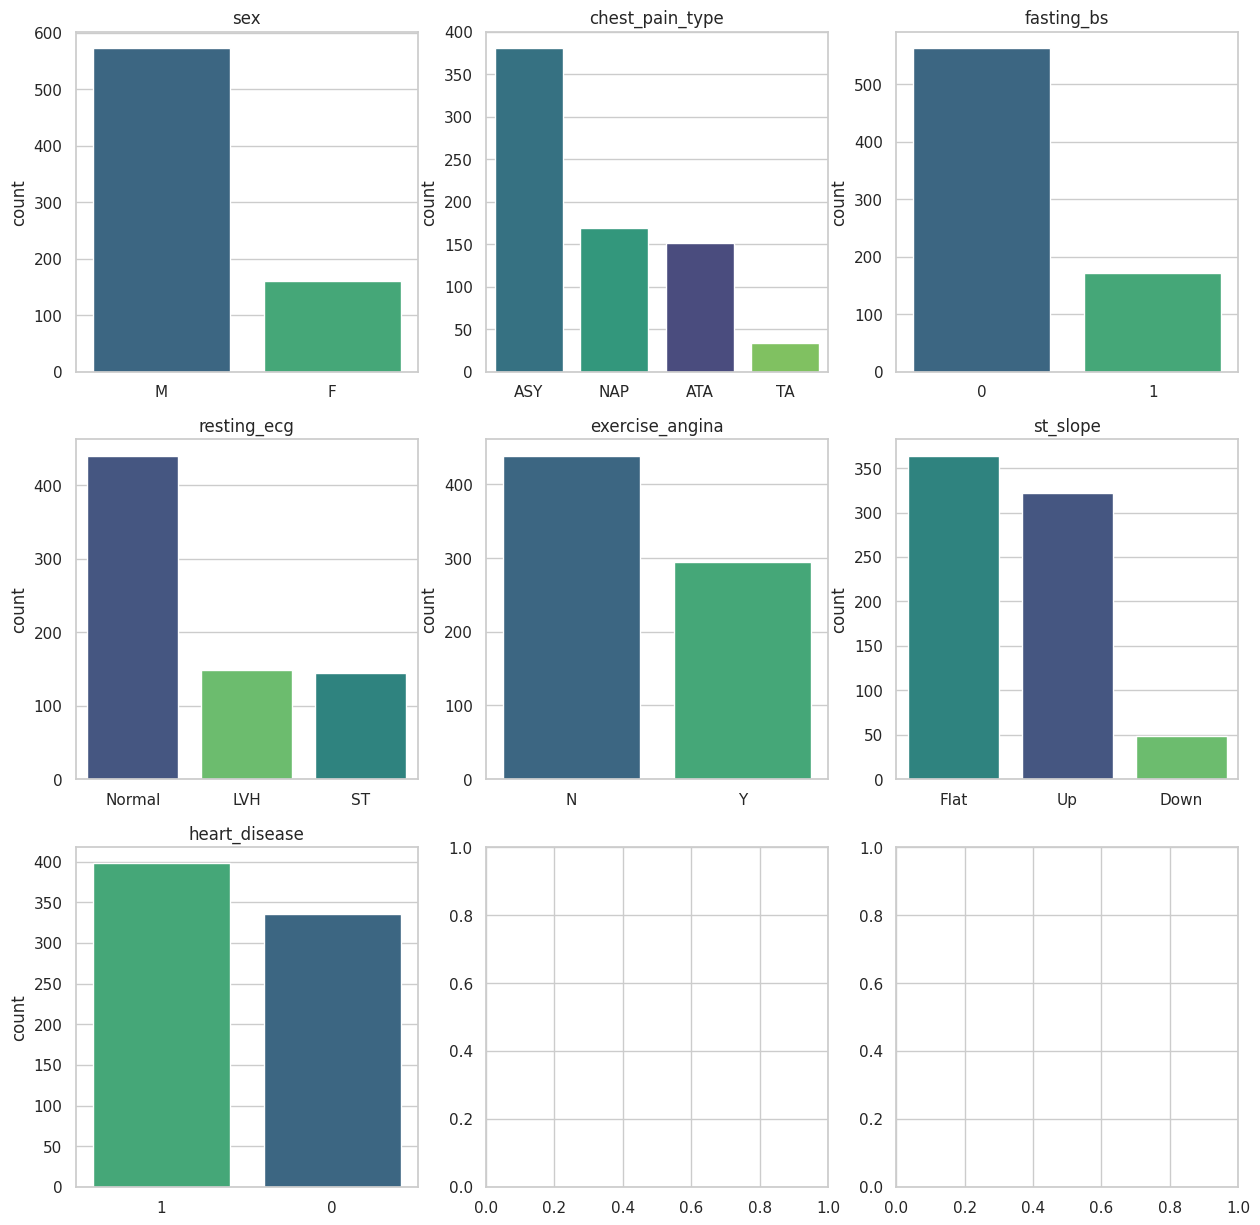

In [30]:
# get list of columns with less than 5 unique values
factor_cols = [col for col in heart_failure.columns if unique_values[col] < 5]

n_cols = 3
n_rows = np.ceil(len(factor_cols)/3).astype(int)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(factor_cols):
    
    ax = axs[i]
    
    # order the bars
    order = heart_failure[col].value_counts().index
    
    sns.countplot(
        data=heart_failure, x=col, ax=ax, order=order,
        hue = col, palette='viridis'
    )
    # remove legend
    ax.legend([],[], frameon=False)
    # remove x label
    ax.set_xlabel('')
    # set title to column name
    ax.set_title(col)

We can see that there are severe class imbalances in most of the featurues but not in the response variable (heart_disease). We will thus proceed without any resamplin or oversampling (e.g. SMOTE) and only apply dummy encoding to the features as class imbalances in the features (and not the response) are usually not concerning. Nevertheless, when interpreting our results in the end we have to keep in mind that we only had very few female training data.

Let's move on to the numeric columns. First, we have a look at some summary statistics and at the number and location of NA observations in our dataframe:

In [ ]:
# some summary statistics:
skim(heart_failure)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 734    │ │ int64       │ 6     │                                                          │
│ │ Number of columns │ 12     │ │ string      │ 5     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ age                 │    0 │       0 │      54 │     9.4 │   29 │    47 │    54 │    60 │     77 │ ▁▃▅▇▅▁  │  │
│ │ resting_bp          │    0 │       0 │     130 │      19 │    0 │   120 │   130 │   140 │    200 │    ▇▆▁  │  │
│ │ cholesterol         │    0 │       0 │     200 │     110 │    0 │   170 │   220 │   270 │    530 │  ▃▁▇▃   │  │
│ │ fasting_bs          │    0 │       0 │    0.23 │    0.42 │    0 │     0 │     0 │     0 │      1 │ ▇    ▂  │  │
│ │ max_hr              │    0 │       0 │     140 │      25 │   60 │   120 │   140 │   160 │    200 │ ▁▂▇▇▇▂  │  │
│ │ oldpeak             │    0 │       0 │    0.87 │     1.1 │   -2 │     0 │   0.5 │   1.5 │    6.2 │   ▇▅▁   │  │
│ │ heart_disease       │    0 │       0 │    0.54 │     0.5 │    0 │     0 │     1 │     1 │      1 │ ▇    ▇  │  │
│ └─────────────────────┴──────┴─────────┴─────────┴─────────┴──────┴───────┴───────┴───────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                     ┃ NA     ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ sex                             │      0 │          0 │                          1 │                   734 │  │
│ │ chest_pain_type                 │      0 │          0 │                          1 │                   734 │  │
│ │ resting_ecg                     │      0 │          0 │                          1 │                   734 │  │
│ │ exercise_angina                 │      0 │          0 │                          1 │                   734 │  │
│ │ st_slope                        │      0 │          0 │                          1 │                   734 │  │
│ └─────────────────────────────────┴────────┴────────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Thus, we are working with seven numeric columns, where fasting_bs (fasting blood sugar) and heart_disease are dummy variables, and five columns involving strings. It is evident, that all numeric features apart from oldpeak are non-negative where a total of 11 observations have a negative oldpeak value (see below). Moreover, we can see that at least one patient has a cholesterol level of 0 and at least one patient has a resting blood pressure of 0, which is impossible. 

 <span style="color:red">Double check negative values!</span>


In [51]:
heart_failure.query('oldpeak <0')

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
259,63,M,ASY,100,0,1,Normal,109,N,-0.9,Flat,1
261,42,M,ASY,105,0,1,Normal,128,Y,-1.5,Down,1
262,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0
266,56,M,ASY,115,0,1,ST,82,N,-1.0,Up,1
267,51,M,ASY,130,0,1,Normal,170,N,-0.7,Up,1
268,62,M,TA,120,0,1,LVH,134,N,-0.8,Flat,1
281,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
330,62,M,ASY,115,0,1,Normal,72,Y,-0.5,Flat,1
335,56,M,NAP,125,0,1,Normal,98,N,-2.0,Flat,1
342,66,M,NAP,120,0,0,ST,120,N,-0.5,Up,0


Hence, we have 11 observations with negative oldpeak

age                0
sex                0
chest_pain_type    0
resting_bp         0
cholesterol        0
fasting_bs         0
resting_ecg        0
max_hr             0
exercise_angina    0
oldpeak            0
st_slope           0
heart_disease      0
dtype: int64


<Axes: >

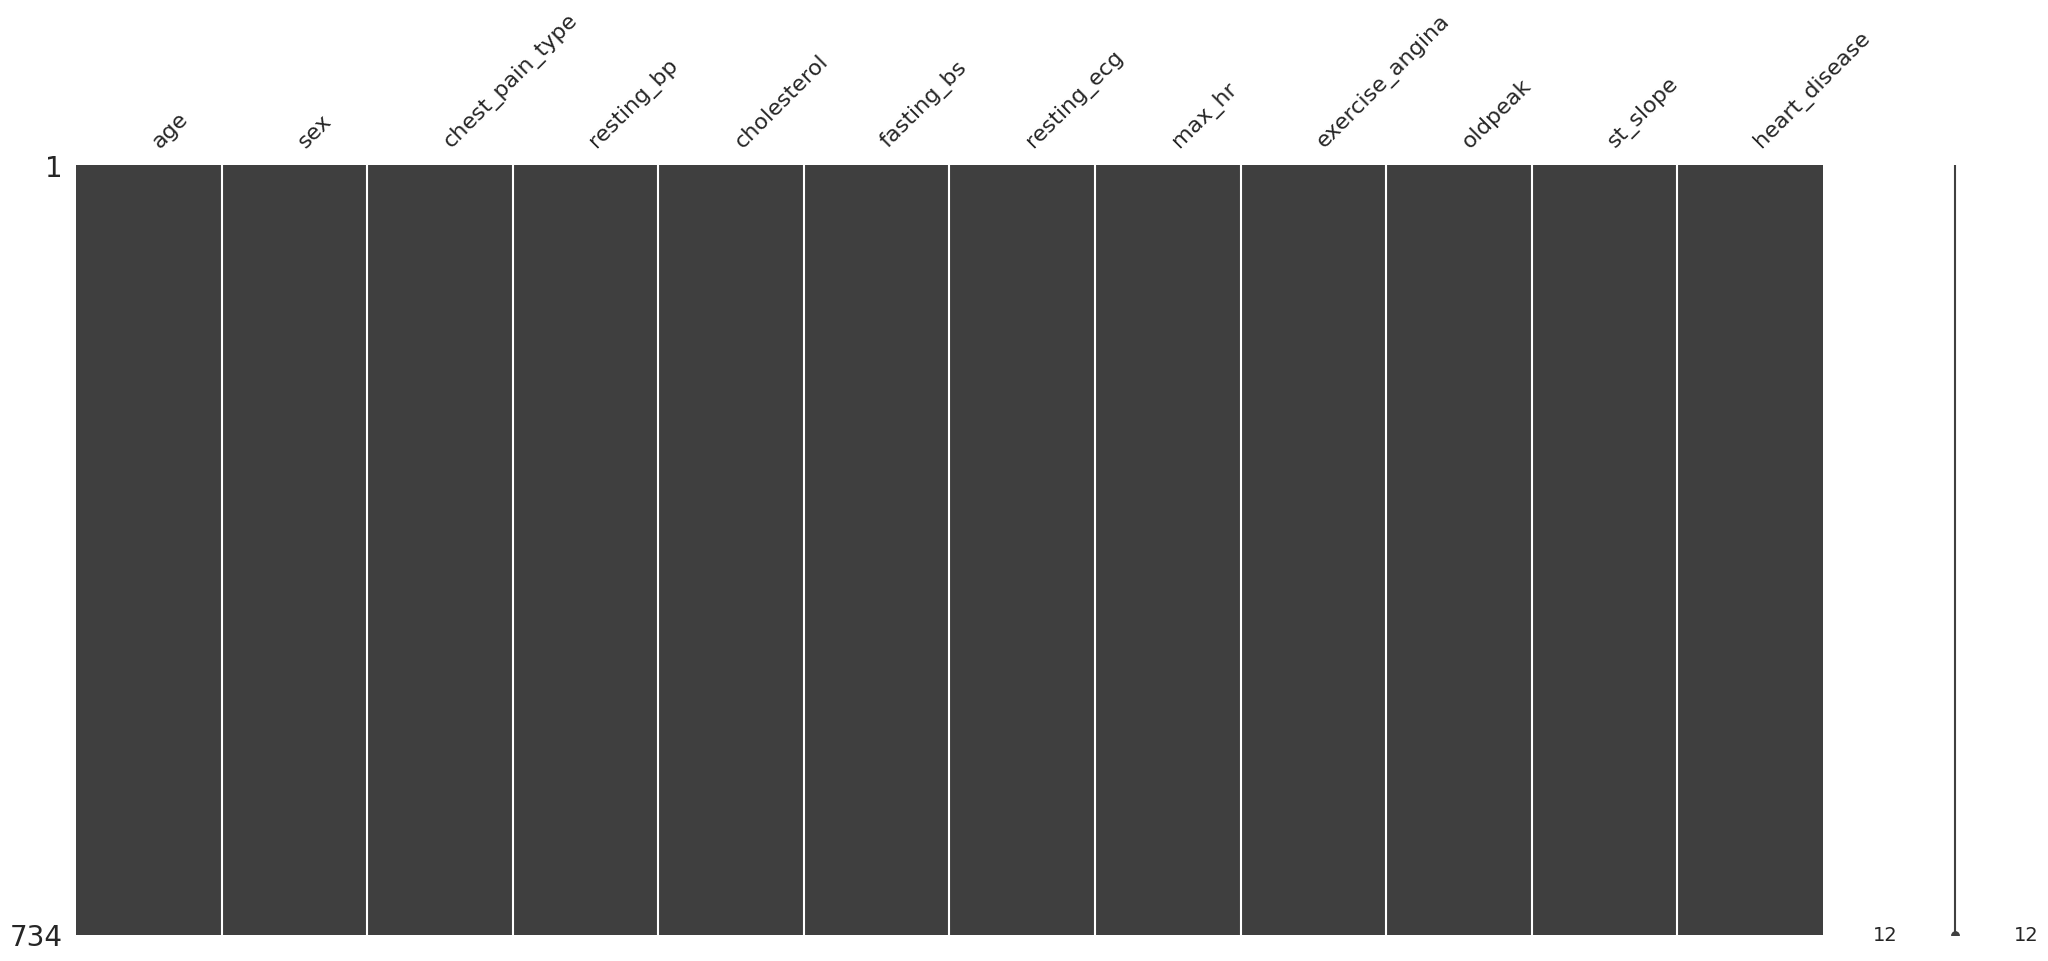

In [72]:
# count missing values
print(heart_failure.isna().sum())
# plot missing values/NAs
msno.matrix(heart_failure)

Luckily, we do not have any NAs in our dataset. We continue by investigating the distributions of the different numeric features

## Pair Plots

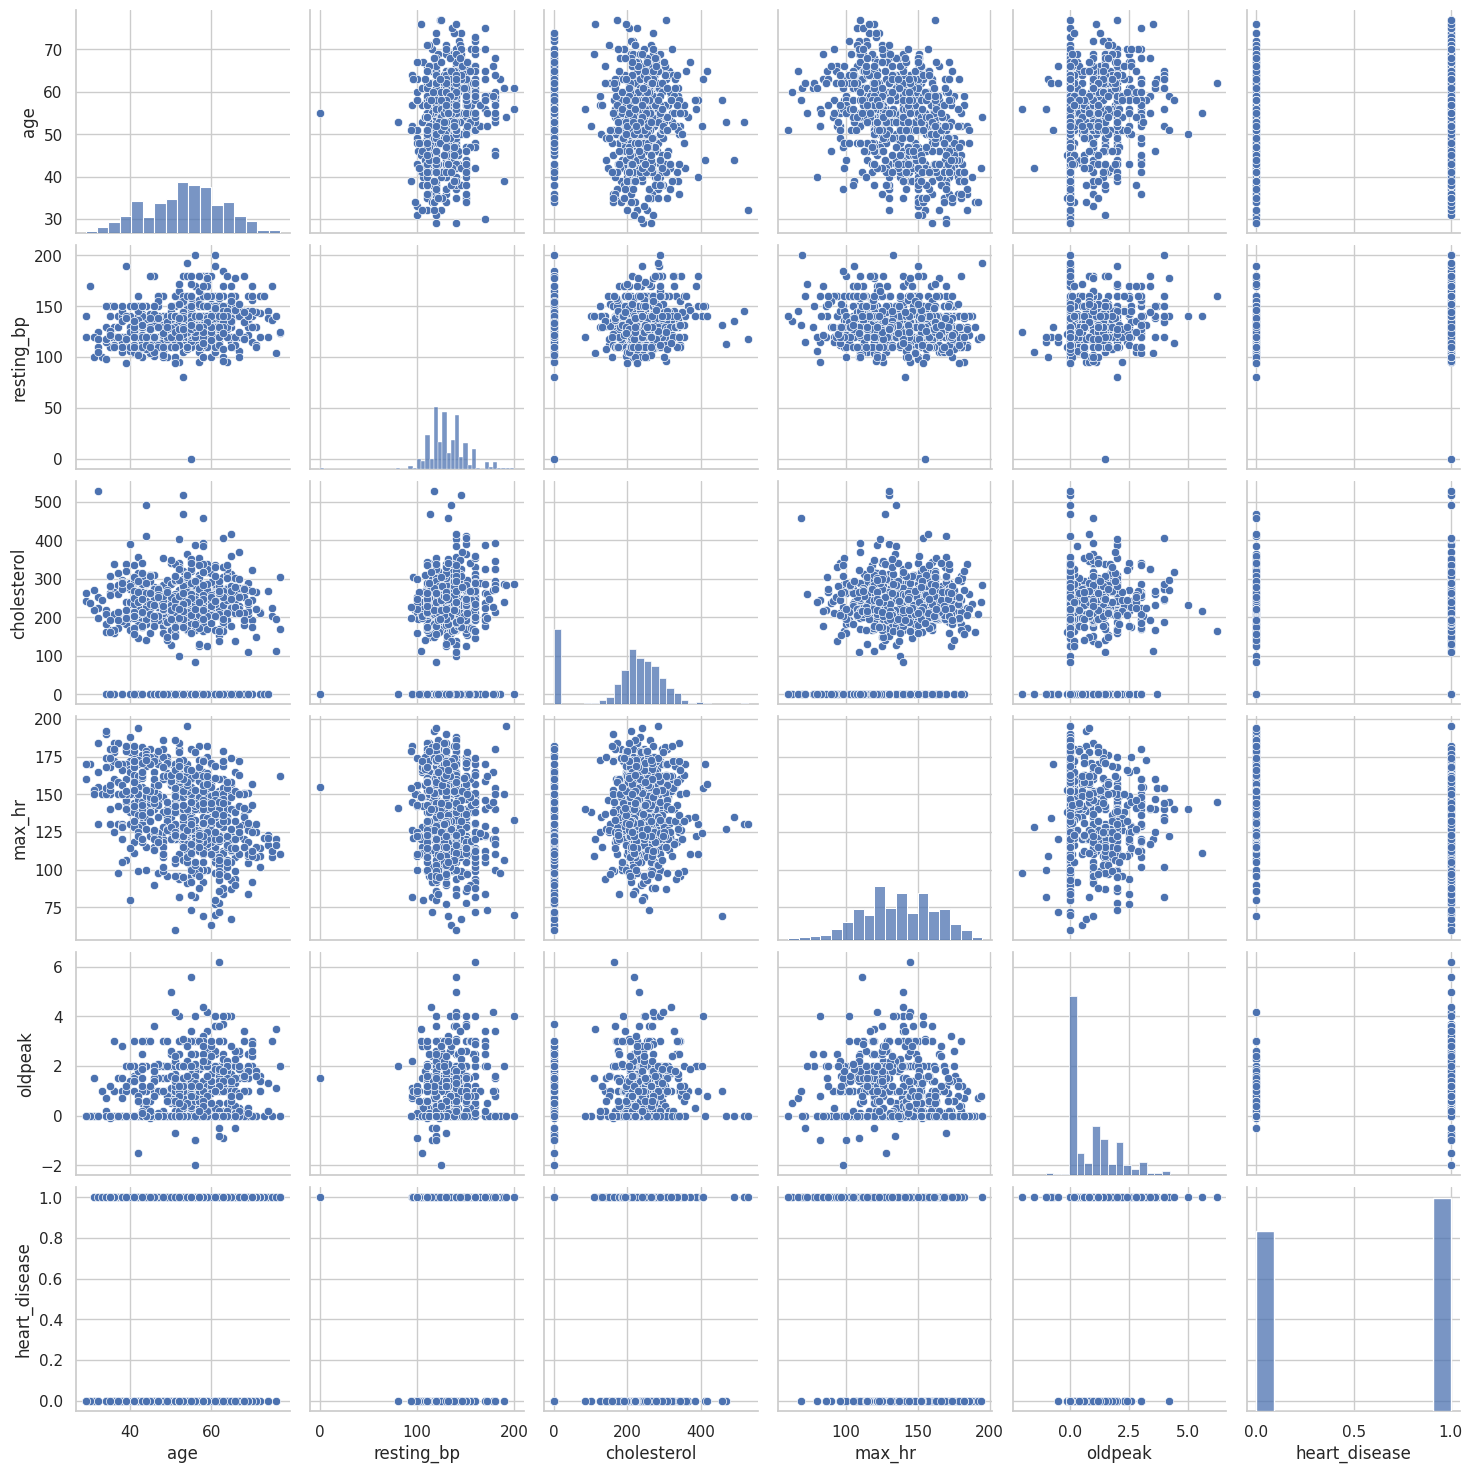

In [82]:
# pairplot of all numeric columns colored by sex
sns.pairplot(
    heart_failure[['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'heart_disease']],
    #diag_kind='kde'
)

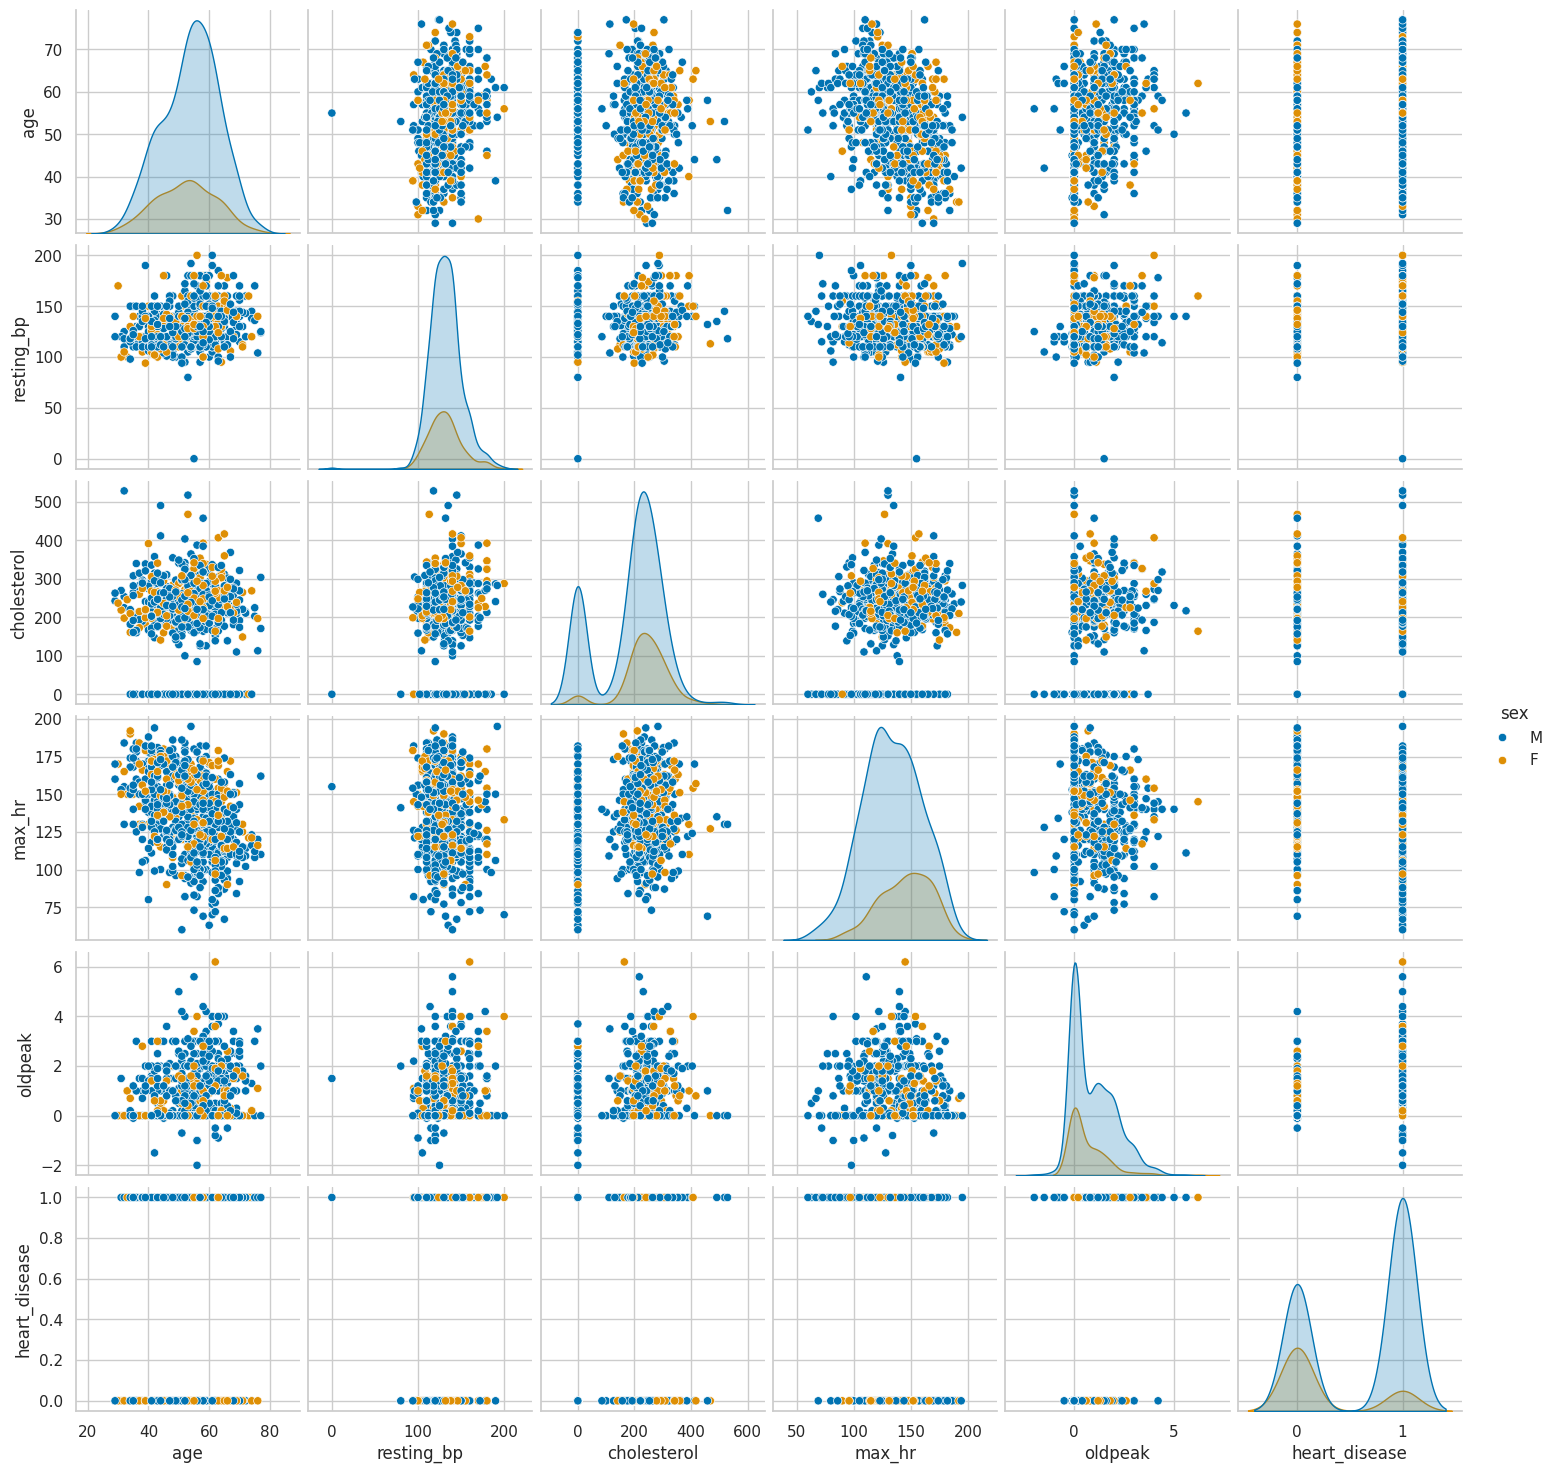

In [84]:
# pairplot of all numeric columns colored by sex
sns.pairplot(
    heart_failure[['sex','age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'heart_disease']],
    diag_kind='kde',
    hue= 'sex',
    palette='colorblind'
)

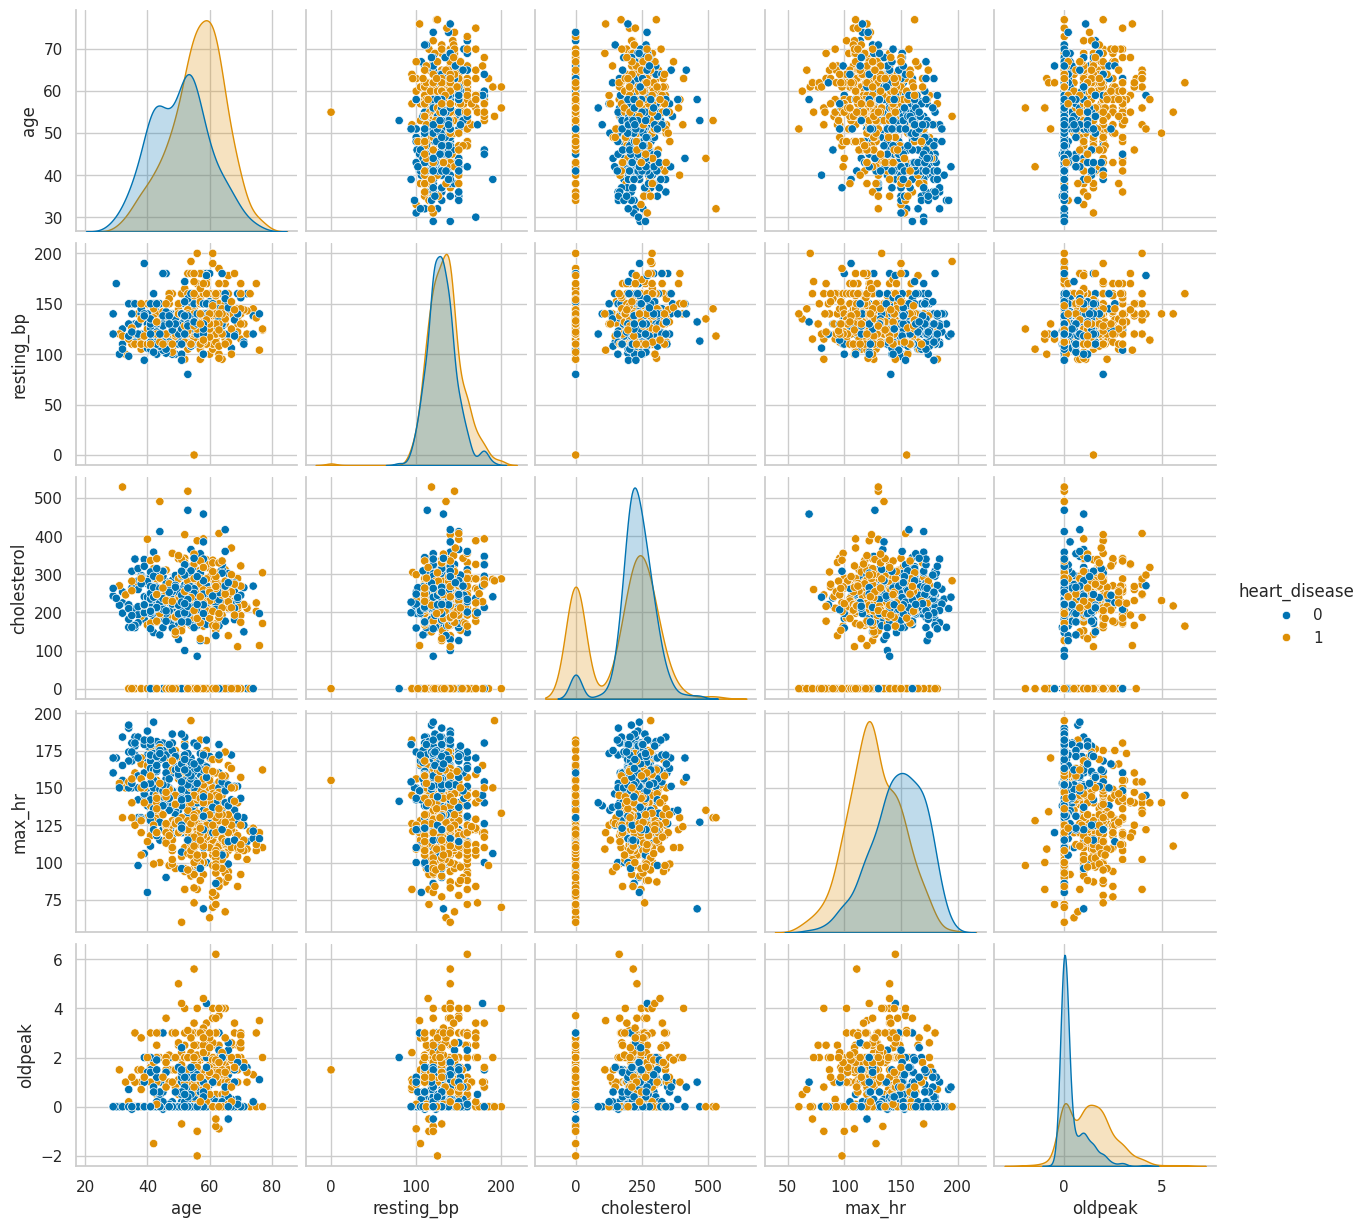

In [61]:
# pairplot of all numeric columns colored by heart_disease
sns.pairplot(
    heart_failure[['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'heart_disease']],
    diag_kind='kde',
    hue= 'heart_disease',
    palette='colorblind'
)

### Correlation Analysis

<Axes: >

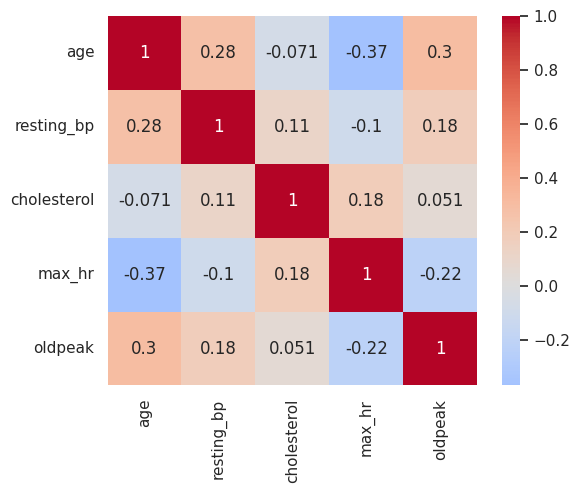

In [79]:
# correlation plot
corr = (
    heart_failure.iloc[:, ~heart_failure.columns.isin(factor_cols)]
    # use spearman due to zero-inflated data and non-negativity of most variables
    .corr(method='spearman')
)

sns.heatmap(corr, cmap='coolwarm', center=0, square=True, annot=True)

## Outliers

### Univariate Outliers

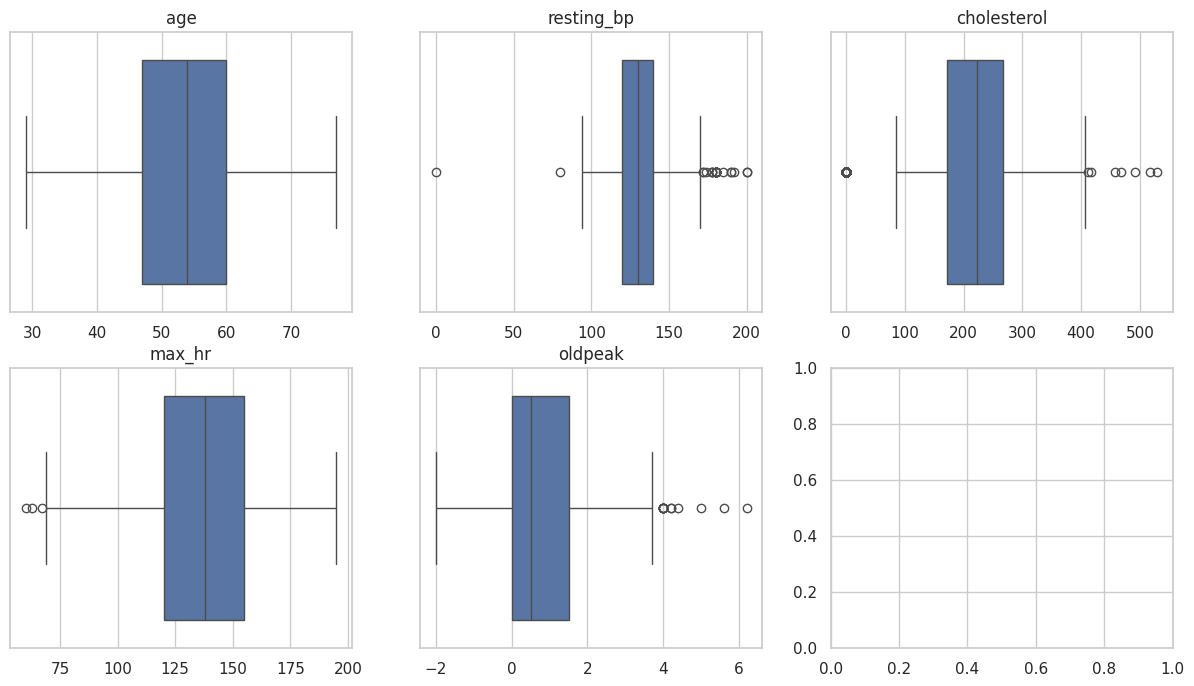

In [94]:
numeric_cols = ['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak']

n_cols = 3
n_rows = np.ceil(len(numeric_cols)/3).astype(int)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    
    ax = axs[i]
    
    # sns.violinplot(
    #     data=heart_failure, x=col, ax=ax, inner = 'box'
    # )
    
    sns.boxplot(
        data=heart_failure, x=col, ax=ax
    )
    
    
    # remove legend
    ax.legend([],[], frameon=False)
    # remove x label
    ax.set_xlabel('')
    # set title to column name
    ax.set_title(col)

### Multivariate Outliers

First, let's have a look at the squared Mahalanobis distance:

Text(0.5, 1.0, 'Chi-square plot')

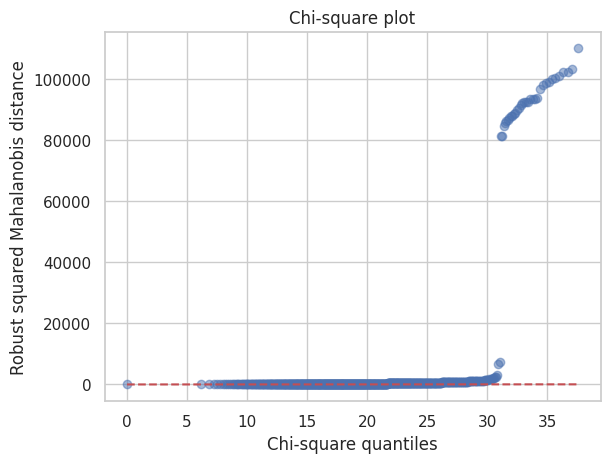

In [115]:
# this implementation is inspired by the code for the chisq.plot function in
# the mvoutlier R package see: 
# https://github.com/cran/mvoutlier/blob/master/R/chisq.plot.R
dummies_hd = pd.get_dummies(heart_failure).drop('heart_disease', axis=1)

# fit robust covariance estimator
mcd = MinCovDet().fit(dummies_hd)
# calculate squared Mahalanobis distance
squared_mahal_dist = mcd.mahalanobis(dummies_hd) ** 2
sorted_squared_mahal_dist = np.sort(squared_mahal_dist)

dof = dummies_hd.shape[1]
quantiles = np.linspace(0., 0.99, len(sorted_squared_mahal_dist))
chi2_quantiles = stats.chi2.ppf(quantiles, dof)

plt.plot(chi2_quantiles, sorted_squared_mahal_dist, 'o', alpha=0.5)
plt.plot(chi2_quantiles, chi2_quantiles, 'r--')
plt.xlabel('Chi-square quantiles')
plt.ylabel('Robust squared Mahalanobis distance')
plt.title('Chi-square plot')

In [121]:
dummies_hd.iloc[np.where(squared_mahal_dist > 1000)[0],:]

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,sex_F,sex_M,chest_pain_type_ASY,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ecg_LVH,resting_ecg_Normal,resting_ecg_ST,exercise_angina_N,exercise_angina_Y,st_slope_Down,st_slope_Flat,st_slope_Up
17,43,100,223,0,142,0.0,True,False,False,False,False,True,False,True,False,True,False,False,False,True
74,43,120,291,0,155,0.0,False,True,False,False,False,True,False,False,True,True,False,False,True,False
134,46,140,272,1,175,2.0,False,True,False,False,False,True,False,True,False,True,False,False,True,False
135,50,140,231,0,140,5.0,False,True,True,False,False,False,False,False,True,False,True,False,True,False
162,57,130,308,0,98,1.0,True,False,False,False,False,True,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,59,134,204,0,162,0.8,False,True,False,False,False,True,False,True,False,True,False,False,False,True
721,58,114,318,0,140,4.4,False,True,True,False,False,False,False,False,True,True,False,True,False,False
722,58,170,225,1,146,2.8,True,False,True,False,False,False,True,False,False,False,True,False,True,False
727,63,140,187,0,144,4.0,False,True,True,False,False,False,True,False,False,False,True,False,False,True


,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,sex_F,sex_M,chest_pain_type_ASY,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ecg_LVH,resting_ecg_Normal,resting_ecg_ST,exercise_angina_N,exercise_angina_Y,st_slope_Down,st_slope_Flat,st_slope_Up


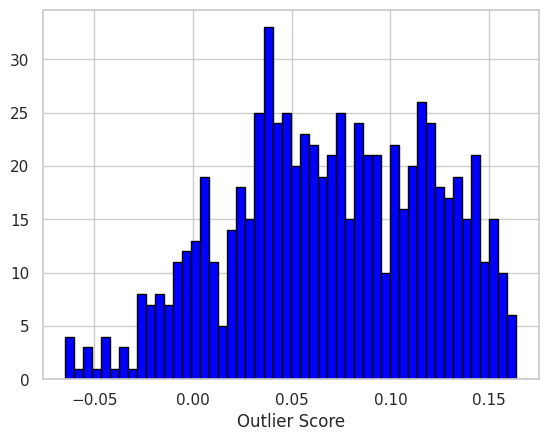

In [104]:
## outlier detection using isolation forest
from sklearn.ensemble import IsolationForest


## Preprocessing for Further Tasks:

This explanatory data analysis suggests the following preprocessing procedure for the upcoming tasks:
- clean the column names (e.g. using skimpy.clean_columns)
- OneHotEncode the factor variables
- Standardize the feature columns